In [1]:
import json
from types import *
from dataloader import *
from util import *
from graphs import *
from agreement import *

data = []

# files = [f'../tutorial/{x}' for x in os.listdir('../tutorial/')]
# files = [f'../preliminary/{x}' for x in os.listdir('../preliminary/')]
files = [f'../annotated/{x}' for x in os.listdir('../annotated/')]

files = sorted(files)

# Only include files of a single batch
batch_num = 4
files = [x for x in files if ('batch_' + str(batch_num)) in x]

# Exclude corrupted file
files = [x for x in files if 'batch_2_rachel' not in x]

print(f'Loading files: {files}\n')

# Add file and append user's name
counter = 0
batches = set([int(x.split('.')[-2].split('_')[-2]) for x in files])
for batch_num in batches:
    for filename in [x for x in files if ('batch_' + str(batch_num)) in x]:
        with open(filename) as f:
            individual_annotation = json.load(f)
            for entry in individual_annotation:
                entry['user'] = filename.split('.')[-2].split('_')[-1]
                entry['batch'] = batch_num
                entry['hit_id'] = entry['id']
                entry['id'] += counter
            data += individual_annotation
    counter += len(individual_annotation)

print(f'Found users: {set([sent["user"] for sent in data])}\n')

data = consolidate_edits(data)          # Adds 'edits' field
data = consolidate_annotations(data)    # Adds 'processed_annotations' field
data = add_simpeval_scores(data)        # Adds 'simpeval_scores' field
data = calculate_sentence_scores(data)  # Adds 'score' field

Loading files: ['../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json']

Found users: {'vinayak', 'rachel', 'vishnesh'}

Couldn't process grammar for annotation: ['positive', 'minor', '', '']


In [2]:
# Print spans with comments
get_comments(data)

RACHEL - HIT 5: When I try to annotate the split, the sentence freezes and no further edits are saved. 
Split-Positive Impact
Efficacy- A lot
No grammar error
And (before thenceforth) is part of the split edit.
Impact- none
No grammar error

RACHEL - HIT 14: "Between" would have been a good substitution, but not having the two events in chronological order makes the sentence more difficult to understand. 

RACHEL - HIT 15: Editing the split causes the sentence to freeze. 
Split
Negative Impact
Severity- Minor
No grammar error
"This was"- part of split edit
Trivial Insertion
No grammar error

VINAYAK - HIT 7: Should be a structure change for the substitution of "the arrival of" to "came into the area" and the reorder of "the storm". The structure change should have been a bad structure change, with a severity of "somewhat." 

VISHNESH - HIT 9: Was not sure how to annotate the missing comma which causes a grammatical error so I annotated it as an insertion for arrived.

VISHNESH - HIT 17

In [3]:
# The systems we looked at
systems = set([x['system'] for x in data])

# Edit types
edit_types = set(data[0]['annotations'].keys())

In [4]:
# Example: Searches for coreference errors
deletions = [process_annotation(k) for k in [i for j in [[x for x in sent['edits'] if x['type'] == 'deletion'] for sent in data] for i in j]]
for d in deletions:
    if d['error_type'] == Error.COREFERENCE:
        print(d)

In [5]:
# Example: Annotations for sentence 0
data[0]['processed_annotations']

[{'edit_type': 'deletion',
  'id': 0,
  'information_impact': <Information.LESS: 'Less Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 2,
  'size': 0.022727272727272728,
  'score': 0.022727272727272728},
 {'edit_type': 'deletion',
  'id': 1,
  'information_impact': <Information.LESS: 'Less Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 2,
  'size': 0.02727272727272727,
  'score': 0.02727272727272727},
 {'edit_type': 'substitution',
  'id': 0,
  'information_impact': <Information.SAME: 'Same Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 2,
  'size': 0.031818181818181815,
  'score': 0.09545454545454544},
 {'edit_type': 'substitution',
  'id': 1,
  'information_impact': <Information.SAME: 'Same Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_t

In [6]:
# Example: Edits for sentence 0
data[0]['edits']

[{'type': 'deletion',
  'id': 0,
  'original_span': (130, 135),
  'simplified_span': None,
  'annotation': ['good', 'no', 'no']},
 {'type': 'deletion',
  'id': 1,
  'original_span': (196, 202),
  'simplified_span': None,
  'annotation': ['good', 'no', 'no']},
 {'type': 'substitution',
  'id': 0,
  'original_span': (99, 110),
  'simplified_span': (99, 103),
  'annotation': ['same', 'positive', 'a lot', '', 'no']},
 {'type': 'substitution',
  'id': 1,
  'original_span': (123, 129),
  'simplified_span': (116, 130),
  'annotation': ['same', 'positive', 'somewhat', '', 'no']},
 {'type': 'insertion',
  'id': 0,
  'original_span': None,
  'simplified_span': (170, 173),
  'annotation': ['trivial', 'no', '', 'no']}]

In [7]:
# Example: Agreement between annotators on edit types
# for edit_type in ['deletion', 'insertion', 'reorder', 'substitution']:
#     print(f'{edit_type} -> {calculate_agreement(data, edit_type, drop_no_spans=True)}')

In [8]:
# TODO: trivial edits on substitutions aren't being processed correctly
# for sent in data:
#     for ann in sent['processed_annotations']:
#         if ann['type'] == Quality.TRIVIAL and ann['rating'] == None:
#             print(sent['id'])
#             print(ann)
#             print(sent['system'])
#             print(sent['system'])
#             print(sent['user'])

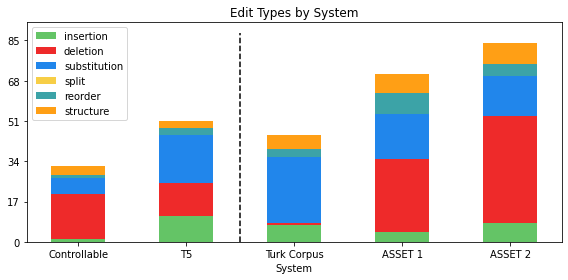

In [9]:
edit_type_by_system(data, flipped=True)

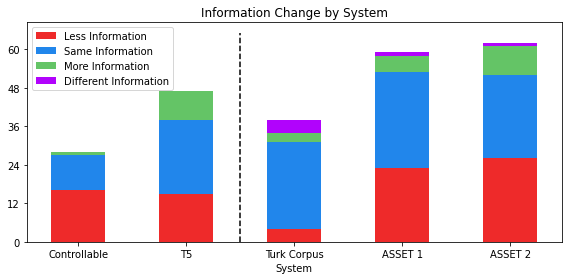

In [10]:
system_by_information_change(data)

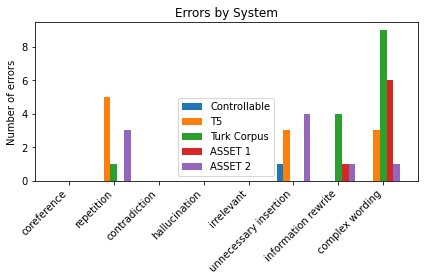

In [11]:
errors_by_system(data)

In [12]:
sankey_seperated(data)

In [13]:
sankey_combined(data)

In [14]:
# Prints the sentences where annotators identified insertion errors
for error in [Error.REPETITION, Error.CONTRADICTION, Error.HALLUCINATION, Error.IRRELEVANT]:
    print(error.value)
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['error_type'] == error:
                print(f'HIT {sent["id"]+1} \t {sent["user"]} \t {system_name_mapping[sent["system"]]}')
    print()

Repetition
HIT 5 	 rachel 	 ASSET 2
HIT 7 	 rachel 	 T5
HIT 14 	 rachel 	 Turk Corpus
HIT 15 	 rachel 	 T5
HIT 5 	 vinayak 	 ASSET 2
HIT 15 	 vinayak 	 T5
HIT 15 	 vinayak 	 T5
HIT 5 	 vishnesh 	 ASSET 2
HIT 15 	 vishnesh 	 T5

Contradiction

Hallucination

Irrelevant



In [15]:
# Print the avg. sentence scores for each system
for s in systems:
    print(f'{system_name_mapping[s]} \t {avg([sent["score"] for sent in data if sent["system"] == s])}')

Controllable 	 0.11
Turk Corpus 	 -0.42
T5 	 -0.11
ASSET 1 	 0.22
ASSET 2 	 0.23


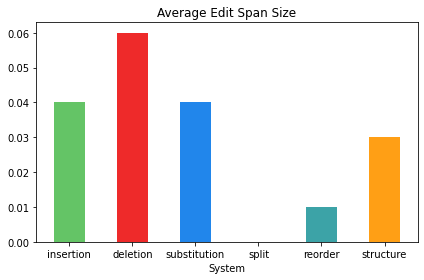

In [16]:
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
avg_span_size(annotations)

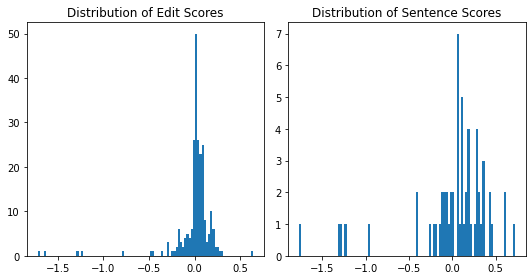

In [17]:
# Show the distribution of edit and sentence scores
score_distribution(data)

In [18]:
# Get the best and worst performing sentences
best, worst = best_performing(data)

Highest Scoring:
vishnesh - Batch 4, HIT 20 (ID 19) - 0.719626168224299
vishnesh - Batch 4, HIT 17 (ID 16) - 0.616822429906542
vinayak - Batch 4, HIT 13 (ID 12) - 0.6167664670658682
vinayak - Batch 4, HIT 19 (ID 18) - 0.4579439252336448
rachel - Batch 4, HIT 5 (ID 4) - 0.4272727272727273

Lowest scoring:
vinayak - Batch 4, HIT 20 (ID 19) - -1.7663551401869158
vinayak - Batch 4, HIT 10 (ID 9) - -1.3032786885245902
rachel - Batch 4, HIT 20 (ID 19) - -1.2897196261682242
rachel - Batch 4, HIT 7 (ID 6) - -1.237704918032787
rachel - Batch 4, HIT 10 (ID 9) - -0.959016393442623


In [19]:
# Get setences with a score of 0
zero_scoring = zero_scoring_sents(data)

rachel - Batch 4, HIT 16 (ID 15)


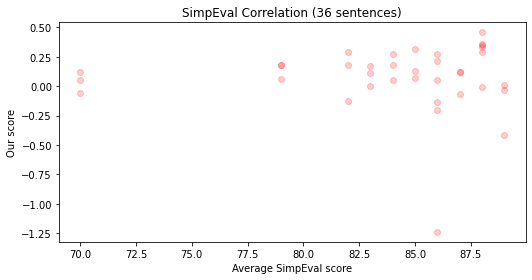

In [20]:
# Show the agreement with SimpEval
simpeval_agreement(data)

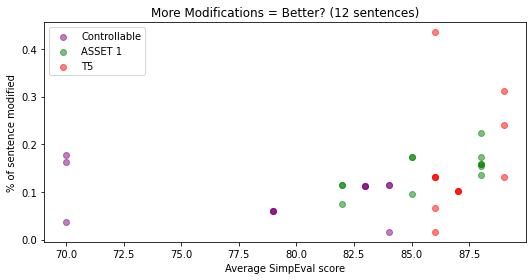

In [21]:
simp_eval_systems = [
    'systems/con_simplification.txt',
    'systems/asset.test.simp',
    'systems/T5.txt'
]
for system in simp_eval_systems:
    scores = [(int(sum(sent['simpeval_scores'])/5), sum([x['size'] for x in sent['processed_annotations']])) for sent in data if sent['system'] == system]
    pts = [p for p in scores if p[0] != 0]
    plt.scatter([p[0] for p in pts], [p[1] for p in pts], c =color_mapping[system], alpha=0.5, label=system_name_mapping[system])
plt.xlabel('Average SimpEval score')
plt.ylabel('% of sentence modified')
plt.title(f'More Modifications = Better? ({len(pts)} sentences)')
plt.legend()
plt.show()

In [22]:
# Some examples of high disagreement
# This isn't the correct way to calculate disagreement between the scores
# high_disagreement = [y[1] for y in sorted([(abs(x[0] - x[1]), i) for i, x in enumerate(scores) if x[0] != 0], reverse=True)][:5]
# for idx in high_disagreement:
#     example = data[idx]
#     print(f'HIT {example["id"] + 1}\nAnnotator: {example["user"]}\nSimpEval Score: {example["simpeval_scores"]}\nOur Score: {example["score"]}\nSystem: {system_name_mapping[example["system"]]}\n')

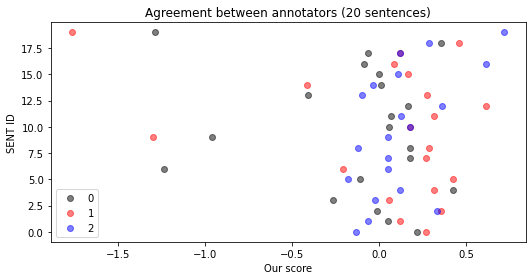

In [23]:
# Calculate the inter-annotator agreement on sentence-level scores
final = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [x['score'] for x in sents]
    final.append(scores)

# Plot the scores for each sentence
ann_mapping = {
    0: 'black',
    1: 'red',
    2: 'blue'
}
for ann in range(0, 3):
    pts = [(i, score) for i, score in enumerate([x[ann] for x in final])]
    plt.scatter([p[1] for p in pts], [p[0] for p in pts], c =ann_mapping[ann], alpha=0.5, label=f'Annotator {ann+1}')
plt.xlabel('Our score')
plt.ylabel('SENT ID')
plt.title(f'Agreement between annotators ({len(pts)} sentences)')
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

In [24]:
# Krippendorff's alpha = calculated by a token being labeled between
# annotators

In [54]:
# Calculates Rough Span Agreement Score
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_annotations_per_token(sents, 'original')
    simp_tokens = get_annotations_per_token(sents, 'simplified')
    agg_score = 0
    for val in list(orig_tokens.values()) + list(simp_tokens.values()):
        agg_score += (list(val.values())[0] - 3)
    total_agreement.append(agg_score)
print(f"Sent with full agreement {sum([x == 0 for x in total_agreement])} / {MAX_HIT}")
hds = sorted([(i, val) for i, val in enumerate(total_agreement)], key=lambda x: x[1])
print("Highest disagreement sentence IDs")
[x[0] for x in hds][:5]

Sent with full agreement 4 / 20
Highest disagreement sentence IDs


[13, 2, 4, 6, 5]

{(8, 13): {'reorder': 1, 'structure': 1},
 (14, 20): {'substitution': 2, 'structure': 1},
 (21, 26): {'substitution': 2, 'structure': 1},
 (27, 30): {'substitution': 2, 'structure': 1},
 (31, 39): {'deletion': 1, 'substitution': 2, 'structure': 1},
 (40, 44): {'substitution': 3, 'structure': 1},
 (45, 47): {'substitution': 1, 'structure': 1},
 (48, 51): {'reorder': 1},
 (52, 58): {'reorder': 1},
 (59, 61): {'deletion': 2},
 (62, 66): {'deletion': 2},
 (67, 69): {'deletion': 2},
 (70, 73): {'deletion': 2},
 (74, 82): {'deletion': 2},
 (83, 85): {'deletion': 2},
 (86, 94): {'deletion': 2},
 (95, 98): {'substitution': 1},
 (99, 110): {'substitution': 3},
 (111, 114): {'substitution': 3},
 (130, 135): {'deletion': 2},
 (141, 145): {'deletion': 1},
 (180, 186): {'deletion': 2},
 (187, 191): {'structure': 1}}

{(8, 11): {'reorder': 1, 'structure': 2},
 (12, 18): {'reorder': 1, 'structure': 2},
 (19, 23): {'substitution': 2, 'structure': 1},
 (24, 31): {'substitution': 3, 'structure': 1},
 (32, 34): {'reorder': 1, 'substitution': 1, 'structure': 1},
 (35, 41): {'reorder': 1},
 (45, 49): {'substitution': 3},
 (50, 54): {'substitution': 3},
 (55, 60): {'substitution': 3},
 (61, 64): {'substitution': 3},
 (65, 72): {'substitution': 3},
 (93, 96): {'insertion': 3},
 (97, 104): {'insertion': 3},
 (134, 137): {'insertion': 2, 'structure': 1}}

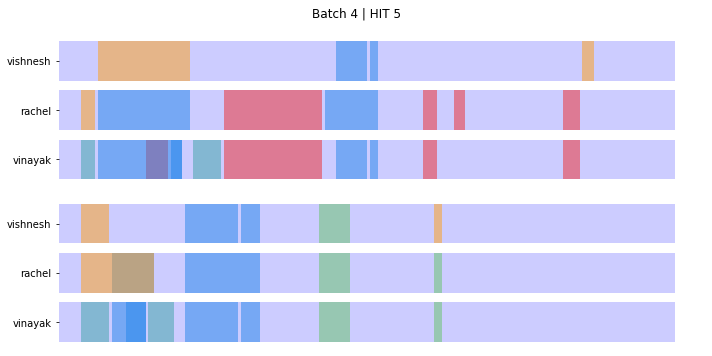

In [56]:
sents = [x for x in data if x['id'] == 4]
orig_tokens = get_annotations_per_token(sents, 'original')
simp_tokens = get_annotations_per_token(sents, 'simplified')

display(orig_tokens)
display(simp_tokens)
draw_agreement(sents)

In [26]:
# Calculates % Agreement
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_annotations_per_token(sents, 'original')
    simp_tokens = get_annotations_per_token(sents, 'simplified')
    total_agreement += list(orig_tokens.values()) + list(simp_tokens.values())

for edit_type in edit_type_labels:
    out = {
        3: 0,
        2: 0,
        1: 0
    }
    for d in total_agreement:
        if edit_type in d.keys():
            if d[edit_type] not in out.keys():
                out[d[edit_type]] = 0
            out[d[edit_type]] += 1
    total = sum(out.values())
    # Avoid division by 0, doesn't change calculation at all
    total = 1 if total == 0 else total
    print(f'{edit_type}: {int(100*out[3]/total)} {int(100*out[2]/total)} {int(100*out[1]/total)}')

insertion: 21 39 39
deletion: 22 40 36
substitution: 23 34 42
split: 0 0 0
reorder: 22 4 73
structure: 5 31 63


In [27]:
# Write down the possible scores for each possible edit type
# To verify scoring is working correctly


<AxesSubplot:>

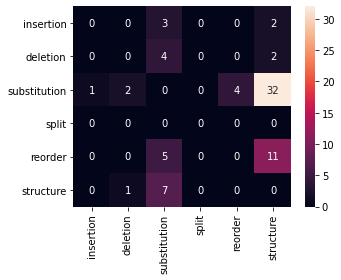

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
ann1, ann2 = [], []

for d in total_agreement:
    # Big asterisk, but we ignore 3 way disagreements
    ks = list(d.keys())
    if len(ks) == 2:
        ann1.append(ks[0])
        ann2.append(ks[1])

a = confusion_matrix(ann1, ann2, labels=edit_type_labels)
df_cm = pd.DataFrame(a, index = [i for i in edit_type_labels],
                  columns = [i for i in edit_type_labels])
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True)

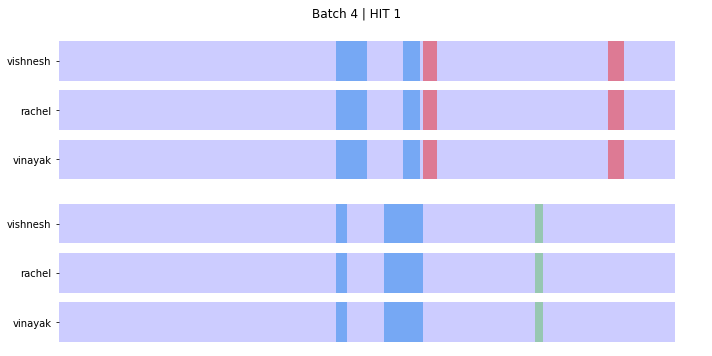

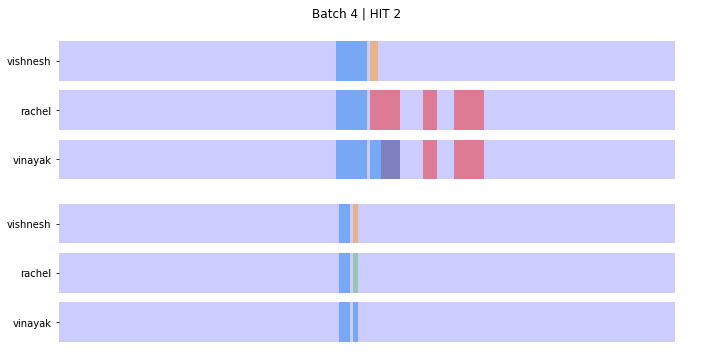

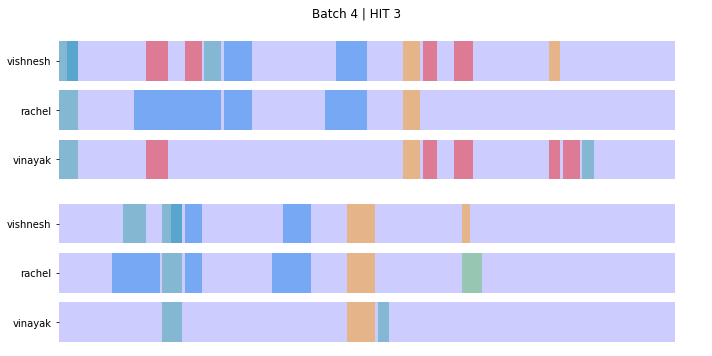

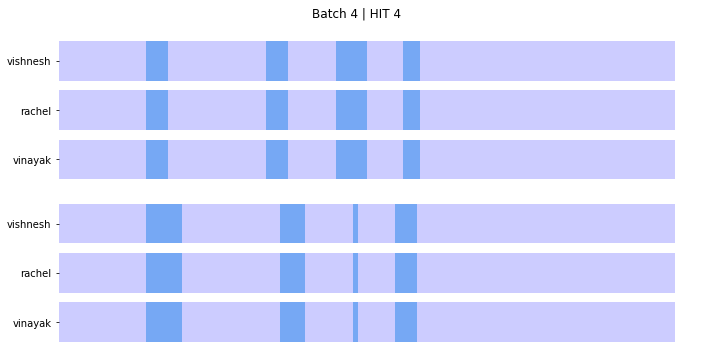

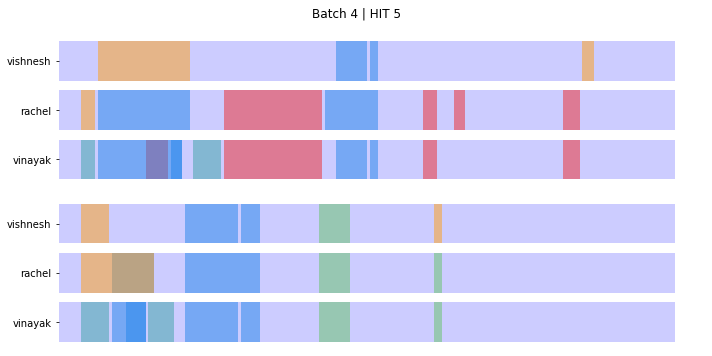

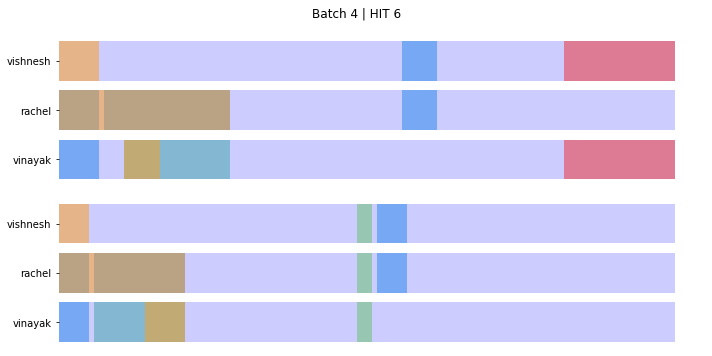

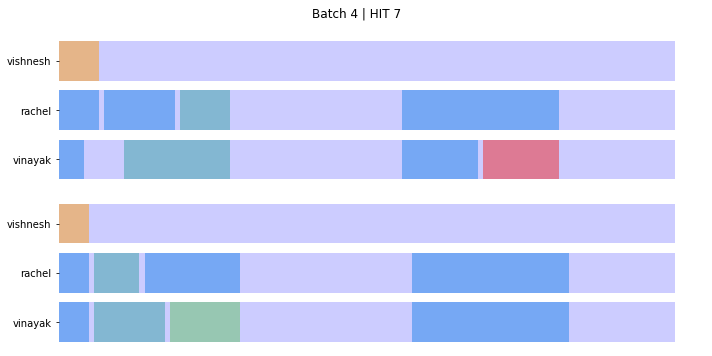

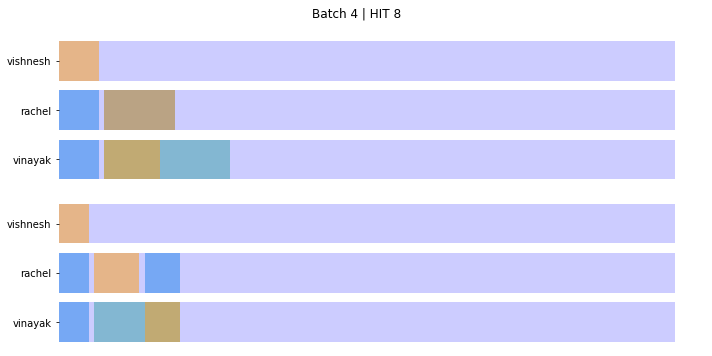

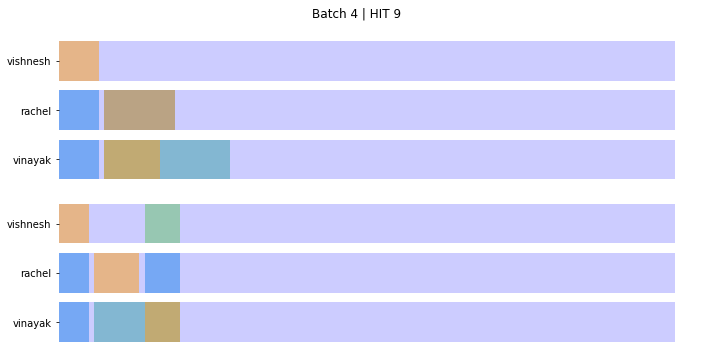

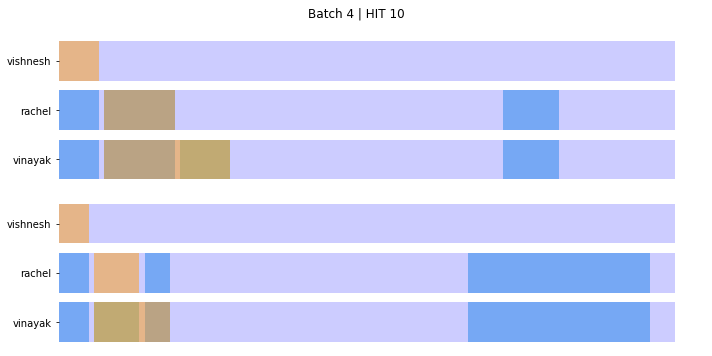

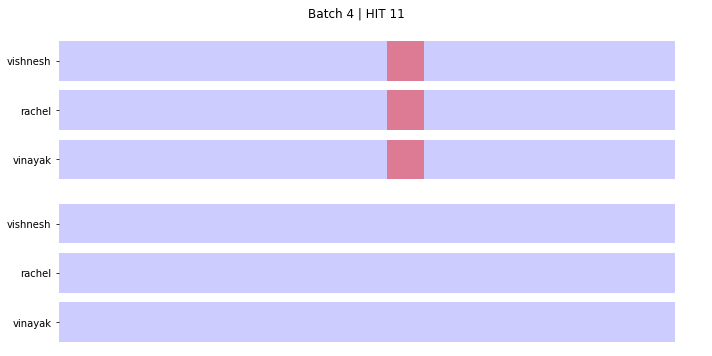

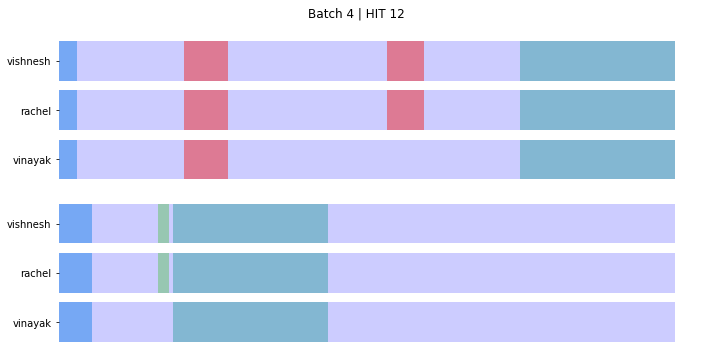

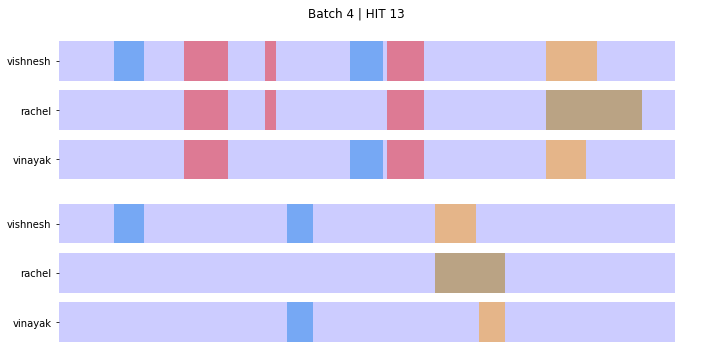

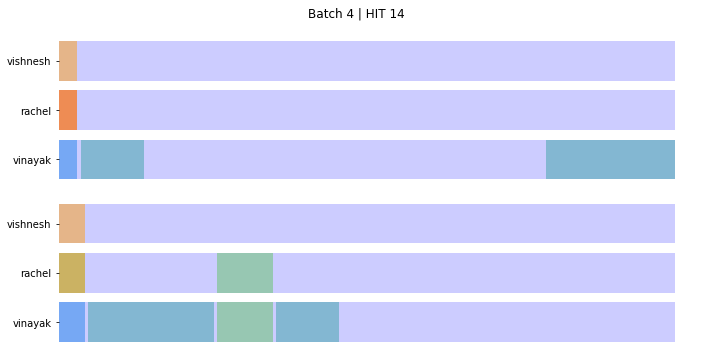

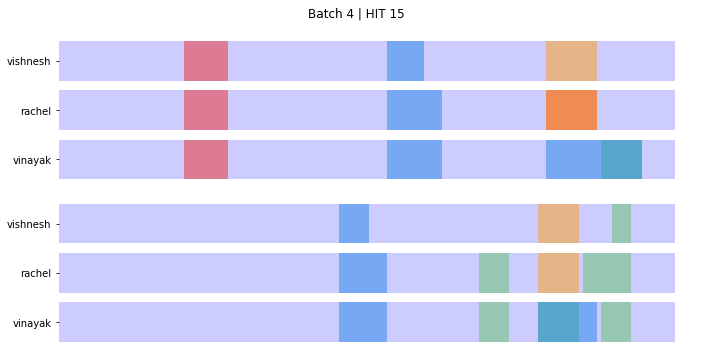

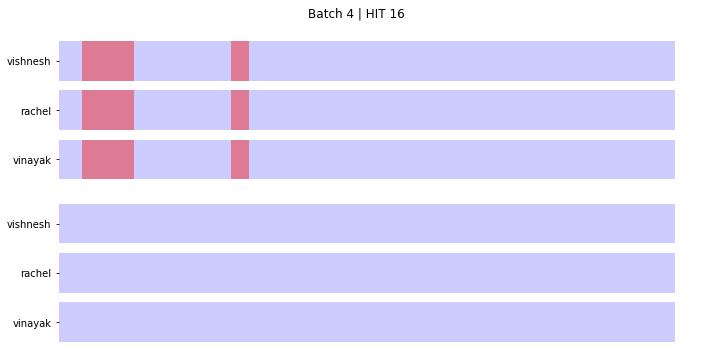

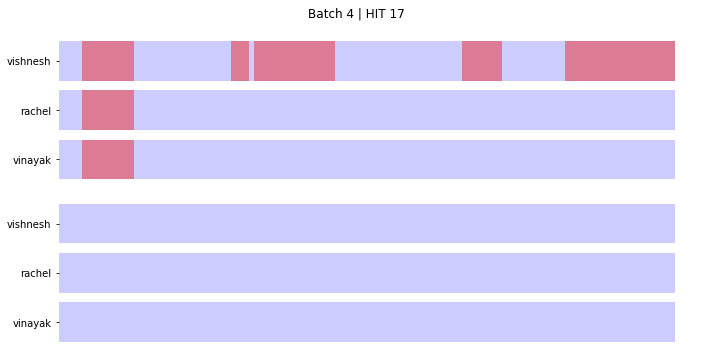

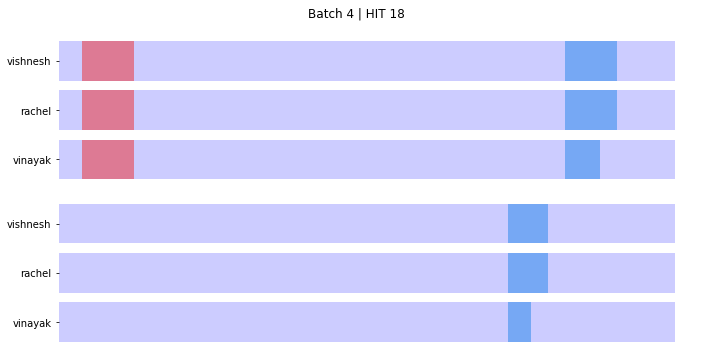

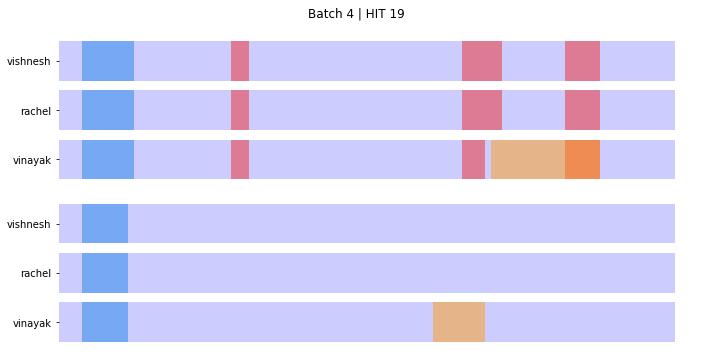

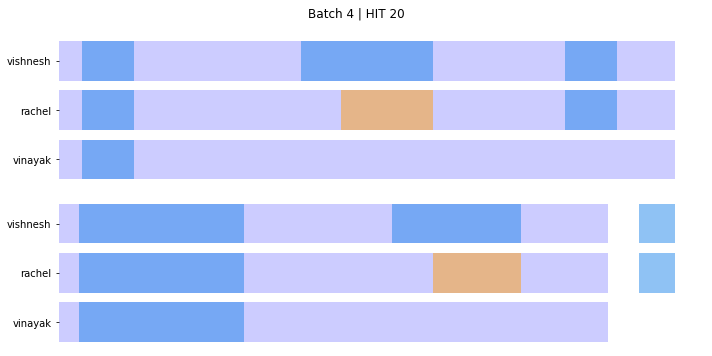

In [29]:
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    draw_agreement(sents)
    